<a href="https://colab.research.google.com/github/wilmi94/MasterThesis-AE-Codes/blob/main/Theisis_ConvLSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicting Coronal Mass Ejections Using Machine Learning Methods

Code/Notebook for final model for master thesis in Aerospace Engineering at FHWN

Code heavily based on Liu et.al 2020

test


## Setup Project

In [ ]:
%%capture 
pip install sunpy

In [ ]:
%%capture 
pip install zeep

In [ ]:
%%capture 
pip install drms

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.optimizers import RMSprop
from tensorflow.python.keras import regularizers
from keras.models import *
from keras.layers import *

from sklearn.utils.class_weight import compute_class_weight
from sunpy.net import Fido, attrs as a
import matplotlib.pyplot as plt
import tensorflow as tf
from astropy.io import fits
from astropy.time import Time
import sunpy.map
import drms
import numpy as np
import pandas as pd
import cv2
import os   

import sys
import csv
import warnings

In [ ]:
# Setup working directory in Google Drive. 
#This way, if your notebook times out, files will be saved in Google Drive!

# the base Google Drive directory
root_dir = "/content/drive/My Drive/"

# choose where you want your project files to be saved
project_folder = "Academia/MSc. Aerospace Engineering - FH Wiener Neustadt/4. Master Thesis/05-notebooks/CME-ConvLSTM"

def create_and_set_working_directory(project_folder):
  # check if your project folder exists. if not, it will be created.
  if os.path.isdir(root_dir + project_folder) == False:
    os.mkdir(root_dir + project_folder)
    print(root_dir + project_folder + ' did not exist but was created.')

  # change the OS to use your project folder as the working directory
  os.chdir(root_dir + project_folder)

  print('\nYour working directory was changed to ' + root_dir + project_folder) #+ \
        #"\nAn empty text file was created there. You can also run !pwd to confirm the current working directory." )

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/My\ Drive/Academia/MSc. Aerospace Engineering - FH Wiener Neustadt/4. Master Thesis/05-notebooks/CME-ConvLSTM

# List files to make sure we're in the expected directory.
# Your output will look different, showing your own Drive files here.
!ls

/content/drive/My Drive/Academia/MSc. Aerospace Engineering - FH Wiener Neustadt/4. Master Thesis/05-notebooks/CME-ConvLSTM
 cme_events.csv      lstm-12-output.csv		  README_cme_data_samples.txt
 CMEpredict.py	     normalized_testing_12.csv	  README_CMEpredict.txt
 gru-12-model.h5     normalized_training_12.csv   test-data
 gru-12-output.csv  'old temp'			  Theisis-ConvLSTM.ipynb
 lstm-12-model.h5    orig			  training-data


In [ ]:
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
try:
    import tensorflow as tf
    tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
except Exception as e:
    print('turn off loggins is not supported')

## Functions

In [ ]:
def load_data(datafile, series_len, start_feature, n_features, mask_value, rnn_type, time_window):
    df = pd.read_csv(datafile)
    df_values0 = df.values
    if rnn_type == 'gru':
        if time_window == 12:
            df_values = df_values0[:,
                        [0, 1, 2, 3, 11, 13, 7, 8, 15, 18, 21, 6, 9, 10, 17, 5, 16, 4, 12, 19, 20, 14]]  # 12   GRU
        elif time_window == 24:
            df_values = df_values0[:,
                        [0, 1, 2, 3, 11, 13, 15, 5, 20, 9, 21, 7, 8, 6, 17, 18, 10, 14, 4, 12, 16, 19]]  # 24   GRU
        elif time_window == 36:
            df_values = df_values0[:,
                        [0, 1, 2, 3, 11, 5, 13, 20, 9, 21, 15, 8, 7, 4, 6, 14, 12, 17, 10, 18, 16, 19]]  # 36   GRU
        elif time_window == 48:
            df_values = df_values0[:,
                        [0, 1, 2, 3, 11, 5, 13, 20, 9, 14, 8, 7, 21, 6, 4, 15, 12, 17, 16, 10, 18, 19]]  # 48   GRU
        elif time_window == 60:
            df_values = df_values0[:,
                        [0, 1, 2, 3, 11, 5, 13, 20, 7, 15, 8, 14, 6, 21, 4, 9, 12, 10, 19, 18, 16, 17]]  # 60   GRU
    elif rnn_type == 'lstm':
        if time_window == 12:
            df_values = df_values0[:,
                        [0, 1, 2, 3, 11, 13, 20, 7, 15, 8, 21, 6, 18, 5, 10, 9, 17, 16, 19, 12, 14, 4]]  # 12   LSTM
        elif time_window == 24:
            df_values = df_values0[:,
                        [0, 1, 2, 3, 20, 11, 13, 9, 15, 14, 8, 7, 5, 21, 6, 17, 18, 10, 12, 16, 4, 19]]  # 24   LSTM
        elif time_window == 36:
            df_values = df_values0[:,
                        [0, 1, 2, 3, 11, 20, 13, 5, 14, 8, 15, 7, 9, 21, 6, 4, 12, 17, 18, 10, 16, 19]]  # 36   LSTM
        elif time_window == 48:
            df_values = df_values0[:,
                        [0, 1, 2, 3, 11, 5, 20, 13, 9, 14, 7, 15, 8, 6, 4, 21, 12, 17, 18, 16, 10, 19]]  # 48   LSTM
        elif time_window == 60:
            df_values = df_values0[:,
                        [0, 1, 2, 3, 11, 5, 13, 20, 7, 15, 8, 14, 6, 21, 4, 9, 12, 10, 19, 18, 16, 17]]  # 60   LSTM
    X = []
    y = []
    tmp = []
    for k in range(start_feature, start_feature + n_features):
        tmp.append(mask_value)
    n_neg = 0
    n_pos = 0
    for idx in range(0, len(df_values)):
        each_series_data = []
        row = df_values[idx]
        label = row[0]
        if label == 'padding':
            continue
        has_zero_record = False
        # if one of the physical feature values is missing, then discard it.
        for k in range(start_feature, start_feature + n_features):
            if float(row[k]) == 0.0:
                has_zero_record = True
                break

        if has_zero_record is False:
            cur_harp_num = int(row[3])
            each_series_data.append(row[start_feature:start_feature + n_features].tolist())
            itr_idx = idx - 1
            while itr_idx >= 0 and len(each_series_data) < series_len:
                prev_row = df_values[itr_idx]
                prev_harp_num = int(prev_row[3])
                if prev_harp_num != cur_harp_num:
                    break
                has_zero_record_tmp = False
                for k in range(start_feature, start_feature + n_features):
                    if float(prev_row[k]) == 0.0:
                        has_zero_record_tmp = True
                        break
                if float(prev_row[-5]) >= 3500 or float(prev_row[-4]) >= 65536 or \
                        abs(float(prev_row[-1]) - float(prev_row[-2])) > 70:
                    has_zero_record_tmp = True

                if len(each_series_data) < series_len and has_zero_record_tmp is True:
                    each_series_data.insert(0, tmp)

                if len(each_series_data) < series_len and has_zero_record_tmp is False:
                    each_series_data.insert(0, prev_row[start_feature:start_feature + n_features].tolist())
                itr_idx -= 1

            while len(each_series_data) > 0 and len(each_series_data) < series_len:
                each_series_data.insert(0, tmp)

            if (label == 'N' or label == 'P') and len(each_series_data) > 0:
                X.append(np.array(each_series_data).reshape(series_len, n_features).tolist())
                if label == 'N':
                    y.append(0)
                    n_neg += 1
                elif label == 'P':
                    y.append(1)
                    n_pos += 1
    X_arr = np.array(X)
    y_arr = np.array(y)
    nb = n_neg + n_pos
    return X_arr, y_arr, nb

In [ ]:
def attention_3d_block(hidden_states, series_len):
    hidden_size = int(hidden_states.shape[2])
    hidden_states_t = Permute((2, 1), name='attention_input_t')(hidden_states)
    hidden_states_t = Reshape((hidden_size, series_len), name='attention_input_reshape')(hidden_states_t)
    score_first_part = Dense(series_len, use_bias=False, name='attention_score_vec')(hidden_states_t)
    score_first_part_t = Permute((2, 1), name='attention_score_vec_t')(score_first_part)
    h_t = Lambda(lambda x: x[:, :, -1], output_shape=(hidden_size, 1), name='last_hidden_state')(hidden_states_t)
    score = dot([score_first_part_t, h_t], [2, 1], name='attention_score')
    attention_weights = Activation('softmax', name='attention_weight')(score)
    context_vector = dot([hidden_states_t, attention_weights], [2, 1], name='context_vector')
    context_vector = Reshape((hidden_size,))(context_vector)
    h_t = Reshape((hidden_size,))(h_t)
    pre_activation = concatenate([context_vector, h_t], name='attention_output')
    attention_vector = Dense(hidden_size, use_bias=False, activation='tanh', name='attention_vector')(pre_activation)
    return attention_vector

In [ ]:
def lstm(n_features, series_len):
    inputs = Input(shape=(series_len, n_features,))
    lstm_out = LSTM(10, return_sequences=True, dropout=0.5, recurrent_dropout=0.3)(inputs)
    attention_mul = attention_3d_block(lstm_out, series_len)
    layer1 = Dense(100, activation='relu')(attention_mul)
    layer1 = Dropout(0.25)(layer1)
    output = Dense(1, activation='sigmoid', activity_regularizer=regularizers.l2(0.0001))(layer1)
    model = Model(inputs=[inputs], outputs=output)
    return model

In [ ]:
def gru(n_features, series_len):
    inputs = Input(shape=(series_len, n_features,))
    lstm_out = GRU(10, return_sequences=True, dropout=0.5, recurrent_dropout=0.3)(inputs)
    attention_mul = attention_3d_block(lstm_out, series_len)
    layer1 = Dense(100, activation='relu')(attention_mul)
    layer1 = Dropout(0.25)(layer1)
    output = Dense(1, activation='sigmoid', activity_regularizer=regularizers.l2(0.0001))(layer1)
    model = Model(inputs=[inputs], outputs=output)
    return model

In [ ]:
def output_result(test_data_file, result_file, rnn_type, time_window, start_feature, n_features, thresh):
    df = pd.read_csv(test_data_file)
    df_values0 = df.values
    if rnn_type == 'gru':
        if time_window == 12:
            df_values = df_values0[:,
                        [0, 1, 2, 3, 11, 13, 7, 8, 15, 18, 21, 6, 9, 10, 17, 5, 16, 4, 12, 19, 20, 14]]  # 12   GRU
        elif time_window == 24:
            df_values = df_values0[:,
                        [0, 1, 2, 3, 11, 13, 15, 5, 20, 9, 21, 7, 8, 6, 17, 18, 10, 14, 4, 12, 16, 19]]  # 24   GRU
        elif time_window == 36:
            df_values = df_values0[:,
                        [0, 1, 2, 3, 11, 5, 13, 20, 9, 21, 15, 8, 7, 4, 6, 14, 12, 17, 10, 18, 16, 19]]  # 36   GRU
        elif time_window == 48:
            df_values = df_values0[:,
                        [0, 1, 2, 3, 11, 5, 13, 20, 9, 14, 8, 7, 21, 6, 4, 15, 12, 17, 16, 10, 18, 19]]  # 48   GRU
        elif time_window == 60:
            df_values = df_values0[:,
                        [0, 1, 2, 3, 11, 5, 13, 20, 7, 15, 8, 14, 6, 21, 4, 9, 12, 10, 19, 18, 16, 17]]  # 60   GRU
    elif rnn_type == 'lstm':
        if time_window == 12:
            df_values = df_values0[:,
                        [0, 1, 2, 3, 11, 13, 20, 7, 15, 8, 21, 6, 18, 5, 10, 9, 17, 16, 19, 12, 14, 4]]  # 12   LSTM
        elif time_window == 24:
            df_values = df_values0[:,
                        [0, 1, 2, 3, 20, 11, 13, 9, 15, 14, 8, 7, 5, 21, 6, 17, 18, 10, 12, 16, 4, 19]]  # 24   LSTM
        elif time_window == 36:
            df_values = df_values0[:,
                        [0, 1, 2, 3, 11, 20, 13, 5, 14, 8, 15, 7, 9, 21, 6, 4, 12, 17, 18, 10, 16, 19]]  # 36   LSTM
        elif time_window == 48:
            df_values = df_values0[:,
                        [0, 1, 2, 3, 11, 5, 20, 13, 9, 14, 7, 15, 8, 6, 4, 21, 12, 17, 18, 16, 10, 19]]  # 48   LSTM
        elif time_window == 60:
            df_values = df_values0[:,
                        [0, 1, 2, 3, 11, 5, 13, 20, 7, 15, 8, 14, 6, 21, 4, 9, 12, 10, 19, 18, 16, 17]]  # 60   LSTM
    with open(result_file, 'w', encoding='UTF-8') as result_csv:
        w = csv.writer(result_csv)
        w.writerow(['Predicted Label', 'Label', 'Timestamp', 'NOAA AR NUM', 'HARP NUM',
                      'TOTUSJH', 'TOTPOT', 'TOTUSJZ', 'ABSNJZH', 'SAVNCPP', 'USFLUX', 'AREA_ACR',
                      'MEANPOT', 'R_VALUE', 'SHRGT45', 'MEANGAM', 'MEANJZH', 'MEANGBT', 'MEANGBZ',
                      'MEANJZD', 'MEANGBH', 'MEANSHR', 'MEANALP'])
        idx = 0
        for i in range(len(df_values)):
            line = df_values[i].tolist()
            if line[0] == 'padding' or float(line[-5]) >= 3500 or float(line[-4]) >= 65536 \
                    or abs(float(line[-1]) - float(line[-2])) > 70:
                continue
            has_zero_record = False
            # if one of the physical feature values is missing, then discard it.
            for k in range(start_feature, start_feature + n_features):
                if float(line[k]) == 0.0:
                    has_zero_record = True
                    break
            if has_zero_record:
                continue
            if prob[idx] >= thresh:
                line.insert(0, 'P')
            else:
                line.insert(0, 'N')
            idx += 1
            w.writerow(line)


In [ ]:
def get_n_features_thresh(rnn_type, time_window):
    n_features = 0
    thresh = 0
    if rnn_type == 'gru':
        if time_window == 12:
            n_features = 16
            thresh = 0.45
        elif time_window == 24:
            n_features = 12
            thresh = 0.4
        elif time_window == 36:
            n_features = 9
            thresh = 0.45
        elif time_window == 48:
            n_features = 14
            thresh = 0.45
        elif time_window == 60:
            n_features = 5
            thresh = 0.5
    elif rnn_type == 'lstm':
        if time_window == 12:
            n_features = 15
            thresh = 0.4
        elif time_window == 24:
            n_features = 12
            thresh = 0.45
        elif time_window == 36:
            n_features = 8
            thresh = 0.45
        elif time_window == 48:
            n_features = 15
            thresh = 0.45
        elif time_window == 60:
            n_features = 6
            thresh = 0.5
    return n_features, thresh

In [ ]:
def download_jsoc_imagedata(eventlist, out_dir):
  '''
  downloads and save FITS (hmi.sharp_cea_720s) files from JSOC 
  input:
    eventlist : datafram
  
  output:
    FITS files in defined download folder

  '''
  fits_data = []
  if not os.path.exists(out_dir):
    os.mkdir(out_dir)


  for index, row in eventlist.iterrows():
    t = row['Timestamp']
    harp_number = row ['HARP_NUM']
    peak_time = Time(t, format='isot', scale='utc').tai
    hmi = 'hmi.sharp_cea_720s[' + str(harp_number) + '][' + str(peak_time) + ']'
    print('\n===== ' + str(index) + ' =====')
    print('query', hmi)
    keys, segments = client.query('hmi.sharp_cea_720s[8][2010-05-05T17:19:34.000]', 
                              key='T_REC, HARPNUM',
                              seg = 'magnetogram') 
    
    url = 'http://jsoc.stanford.edu' + segments.magnetogram[0] 
    data = fits.getdata(url)  
    ex = hmi + '{magnetogram}'
    export_request = client.export(ex, method='url', protocol='fits')  
    export_request.wait() 
    export_request.download(out_dir)  

In [ ]:
def save_image(map_data, out_dir):
  if not os.path.exists(out_dir):
    os.mkdir(out_dir)
    
  figure = plt.figure(frameon=False)
  ax = plt.axes([0, 0, 1, 1])
  # Disable the axis
  ax.set_axis_off()

  # Plot the map. Since are not interested in the exact map coordinates, we can
  # simply use :meth:`~matplotlib.Axes.imshow`.
  norm = map_data.plot_settings['norm']
  norm.vmin, norm.vmax = np.percentile(map_data.data, [1, 99.9])
  map_name = out_dir + '/' + str(map_data.name) +'.png'
  ax.imshow(map_data.data,
          norm=norm,
          cmap=map_data.plot_settings['cmap'],
          origin="lower")
  plt.savefig(map_name)

## Get Data

### load event list

In [ ]:
df_cme_training_eventlist = pd.read_csv(r'normalized_training_12.csv', sep = ',')
df_cme_training_eventlist

,Label,Timestamp,NOAA_AR_NUM,HARP_NUM,TOTUSJH,TOTPOT,TOTUSJZ,ABSNJZH,SAVNCPP,USFLUX,...,R_VALUE,SHRGT45,MEANGAM,MEANJZH,MEANGBT,MEANGBZ,MEANJZD,MEANGBH,MEANSHR,MEANALP
0,N,2010-05-05T05:22:22.90Z,11069,8,-0.5461,-0.5672,-0.6696,0.3159,0.2083,-0.7610,...,0.3751,-0.4109,-0.1049,-3.3554,0.5327,0.6921,-0.1673,0.5768,-0.1024,-1.1464
1,N,2010-05-05T05:34:22.90Z,11069,8,-0.5438,-0.5635,-0.6607,0.3360,0.2741,-0.7552,...,0.3969,-0.3188,-0.0283,-3.2984,0.4808,0.6302,-0.0497,0.5683,-0.0324,-1.1596
2,N,2010-05-05T05:46:22.90Z,11069,8,-0.5469,-0.5604,-0.6521,0.3315,0.3650,-0.7518,...,0.3961,-0.2149,0.0489,-3.1799,0.4268,0.5787,-0.1523,0.5588,0.0503,-1.1509
3,N,2010-05-05T06:22:22.90Z,11069,8,-0.5275,-0.5546,-0.6356,0.3042,0.2075,-0.7346,...,0.3842,-0.2724,0.0144,-2.9791,0.4130,0.5345,-0.0549,0.5549,0.0166,-1.0816
4,N,2010-05-05T06:34:22.90Z,11069,8,-0.5212,-0.5481,-0.6294,0.3653,0.2579,-0.7322,...,0.3554,-0.2530,0.0585,-3.1240,0.4596,0.6073,0.1217,0.5626,0.0660,-1.1460
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20342,N,2016-01-01T21:22:08.10Z,12473,6206,-0.1337,-0.3794,-0.2147,0.0111,0.1896,0.4001,...,0.1159,-0.9110,-0.7764,0.5162,-0.3804,-0.4726,-0.1979,0.3359,-0.8796,0.2120
20343,N,2016-01-01T21:34:08.10Z,12473,6206,-0.1432,-0.3795,-0.2242,-0.0121,0.1277,0.3903,...,0.1068,-0.9101,-0.7861,0.5043,-0.3934,-0.4952,-0.3159,0.3369,-0.8832,0.2054
20344,N,2016-01-01T21:46:08.10Z,12473,6206,-0.0878,-0.3709,-0.1584,0.1223,0.2679,0.3994,...,0.1854,-0.8860,-0.7960,0.6107,-0.3458,-0.4188,-0.3349,0.3392,-0.8464,0.2491
20345,N,2016-01-01T21:58:08.10Z,12473,6206,-0.0918,-0.3703,-0.1676,0.0561,0.2077,0.4215,...,0.1250,-0.9058,-0.7910,0.5466,-0.3614,-0.4533,-0.2073,0.3389,-0.8498,0.2240


In [ ]:
df_cme_testing_eventlist = pd.read_csv(r'normalized_testing_12.csv', sep = ',')
df_cme_testing_eventlist

,Label,Timestamp,NOAA_AR_NUM,HARP_NUM,TOTUSJH,TOTPOT,TOTUSJZ,ABSNJZH,SAVNCPP,USFLUX,...,R_VALUE,SHRGT45,MEANGAM,MEANJZH,MEANGBT,MEANGBZ,MEANJZD,MEANGBH,MEANSHR,MEANALP
0,N,2016-02-11T22:58:09.90Z,12497,6327,0.3925,-0.2331,0.4536,0.9205,1.0290,-0.0909,...,0.3442,-0.0754,0.3384,-1.6783,1.2374,1.1869,0.5194,0.6876,0.1579,-0.7577
1,N,2016-02-11T23:10:09.90Z,12497,6327,0.4030,-0.2328,0.4527,0.9448,0.9703,-0.0821,...,0.3969,-0.1284,0.3151,-1.6798,1.2349,1.1826,1.1634,0.6851,0.1416,-0.7672
2,N,2016-02-11T23:22:09.90Z,12497,6327,0.4127,-0.2295,0.4665,1.0729,1.1235,-0.0793,...,0.4348,-0.1012,0.3018,-1.8024,1.2517,1.1898,1.1432,0.6877,0.1457,-0.8262
3,N,2016-02-11T23:34:10.00Z,12497,6327,0.4183,-0.2292,0.4679,1.0541,1.0207,-0.0777,...,0.4516,-0.1595,0.2761,-1.7795,1.2329,1.1921,1.2066,0.6774,0.1143,-0.8189
4,N,2016-02-11T23:46:10.00Z,12497,6327,0.3991,-0.2277,0.4601,1.1108,1.0915,-0.0865,...,0.4488,-0.1515,0.2837,-1.8467,1.2195,1.1594,1.0569,0.6803,0.1153,-0.8529
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1307,N,2017-09-08T21:46:41.50Z,12673,7115,1.4272,1.4030,0.9736,1.7812,0.8460,1.5846,...,0.7080,0.4347,0.2715,-1.2614,-0.6455,-0.3851,-0.5253,0.4394,0.3891,-0.3652
1308,N,2017-09-08T21:58:41.50Z,12673,7115,1.4111,1.3996,0.9547,1.7520,0.8376,1.5784,...,0.7207,0.4189,0.2718,-1.2425,-0.6451,-0.3957,-0.5757,0.4402,0.3854,-0.3633
1309,N,2017-09-08T22:10:41.50Z,12673,7115,1.3666,1.4062,0.9289,1.7978,1.0682,1.5669,...,0.7066,0.4591,0.2959,-1.2594,-0.7004,-0.4847,-0.5818,0.4354,0.4074,-0.3730
1310,N,2017-09-08T22:22:41.50Z,12673,7115,1.3618,1.3842,0.9619,1.7199,1.0278,1.5788,...,0.6890,0.4209,0.2913,-1.2091,-0.6998,-0.4691,-0.6099,0.4320,0.3894,-0.3614


### download images from JSOC database

In [ ]:
client = drms.Client(email= 'ender.wilmar@gmail.com', verbose=False)  
si = client.info('hmi.sharp_cea_720s')
#print(si.segments.index.values) 

In [ ]:
download_jsoc_imagedata(df_cme_testing_eventlist, 'test-data')


===== 0 =====
query hmi.sharp_cea_720s[6327][2016-02-11T22:58:45.900]

===== 1 =====
query hmi.sharp_cea_720s[6327][2016-02-11T23:10:45.900]

===== 2 =====
query hmi.sharp_cea_720s[6327][2016-02-11T23:22:45.900]

===== 3 =====
query hmi.sharp_cea_720s[6327][2016-02-11T23:34:46.000]

===== 4 =====
query hmi.sharp_cea_720s[6327][2016-02-11T23:46:46.000]

===== 5 =====
query hmi.sharp_cea_720s[6327][2016-02-11T23:58:46.000]

===== 6 =====
query hmi.sharp_cea_720s[6327][2016-02-12T00:10:46.000]

===== 7 =====
query hmi.sharp_cea_720s[6327][2016-02-12T00:22:46.000]

===== 8 =====
query hmi.sharp_cea_720s[6327][2016-02-12T00:34:46.000]

===== 9 =====
query hmi.sharp_cea_720s[6327][2016-02-12T00:46:46.000]

===== 10 =====
query hmi.sharp_cea_720s[6327][2016-02-12T00:58:46.000]

===== 11 =====
query hmi.sharp_cea_720s[6327][2016-02-12T01:10:46.000]

===== 12 =====
query hmi.sharp_cea_720s[6327][2016-02-12T01:22:46.000]

===== 13 =====
query hmi.sharp_cea_720s[6327][2016-02-12T01:34:46.000]

=

DrmsExportError: ignored

In [ ]:
for filename in os.listdir('test-data'):
    f = os.path.join('test-data', filename)
    # checking if it is a file
    if os.path.isfile(f):
      print(f)
      map_mag = sunpy.map.Map(f)
      save_image(map_mag, 'test-data')
      plt.close()

test-data/hmi.sharp_cea_720s.6327.20160211_230000_TAI.magnetogram.fits
test-data/hmi.sharp_cea_720s.6327.20160211_231200_TAI.magnetogram.fits
test-data/hmi.sharp_cea_720s.6327.20160211_232400_TAI.magnetogram.fits
test-data/hmi.sharp_cea_720s.6327.20160211_233600_TAI.magnetogram.fits
test-data/hmi.sharp_cea_720s.6327.20160211_234800_TAI.magnetogram.fits
test-data/hmi.sharp_cea_720s.6327.20160212_000000_TAI.magnetogram.fits
test-data/hmi.sharp_cea_720s.6327.20160212_001200_TAI.magnetogram.fits
test-data/hmi.sharp_cea_720s.6327.20160212_002400_TAI.magnetogram.fits
test-data/hmi.sharp_cea_720s.6327.20160212_003600_TAI.magnetogram.fits
test-data/hmi.sharp_cea_720s.6327.20160212_004800_TAI.magnetogram.fits
test-data/hmi.sharp_cea_720s.6327.20160212_010000_TAI.magnetogram.fits
test-data/hmi.sharp_cea_720s.6327.20160212_011200_TAI.magnetogram.fits
test-data/hmi.sharp_cea_720s.6327.20160212_012400_TAI.magnetogram.fits
test-data/hmi.sharp_cea_720s.6327.20160212_013600_TAI.magnetogram.fits
test-d

In [ ]:
download_jsoc_imagedata(df_cme_training_eventlist, 'test-data')

Streaming output truncated to the last 5000 lines.
===== 1744 =====
query hmi.sharp_cea_720s[750][2011-08-01T21:22:59.900]

===== 1745 =====
query hmi.sharp_cea_720s[750][2011-08-01T21:34:59.900]

===== 1746 =====
query hmi.sharp_cea_720s[750][2011-08-01T21:46:59.900]

===== 1747 =====
query hmi.sharp_cea_720s[750][2011-08-01T21:58:59.900]

===== 1748 =====
query hmi.sharp_cea_720s[750][2011-08-01T22:10:59.900]

===== 1749 =====
query hmi.sharp_cea_720s[750][2011-08-01T22:22:59.900]

===== 1750 =====
query hmi.sharp_cea_720s[750][2011-08-01T22:34:59.900]

===== 1751 =====
query hmi.sharp_cea_720s[750][2011-08-01T22:46:59.900]

===== 1752 =====
query hmi.sharp_cea_720s[750][2011-08-01T22:58:59.900]

===== 1753 =====
query hmi.sharp_cea_720s[750][2011-08-01T23:10:59.900]

===== 1754 =====
query hmi.sharp_cea_720s[750][2011-08-01T23:22:59.900]

===== 1755 =====
query hmi.sharp_cea_720s[750][2011-08-01T23:34:59.900]

===== 1756 =====
query hmi.sharp_cea_720s[750][2011-08-01T23:46:59.900]



AttributeError: ignored

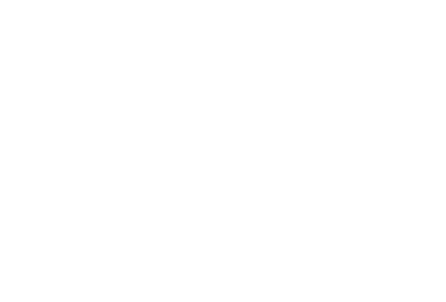

In [ ]:
save_image(df_cme_training_eventlist, 'training-data')

## Define Parameter

In [ ]:
rnn_type = 'lstm' 
time_window = 12 # hr
train_again = 0  # 0 denotes that the program will load and use the pre-trained model

train_data_file = './normalized_training_' + str(time_window) + '.csv'
test_data_file = './normalized_testing_' + str(time_window) + '.csv'
result_file = './' + rnn_type + '-' + str(time_window) + '-output.csv'
model_file = './' + rnn_type + '-' + str(time_window) + '-model.h5'

start_feature = 4
n_features, thresh = get_n_features_thresh(rnn_type, time_window)
mask_value = 0
series_len = 20 # m
epochs = 20
batch_size = 256
nclass = 2

In [ ]:
print(train_data_file)
print(test_data_file)
print(result_file)
print(model_file)

./normalized_training_12.csv
./normalized_testing_12.csv
./lstm-12-output.csv
./lstm-12-model.h5


In [ ]:
pd.read_csv(train_data_file)

,Label,Timestamp,NOAA_AR_NUM,HARP_NUM,TOTUSJH,TOTPOT,TOTUSJZ,ABSNJZH,SAVNCPP,USFLUX,...,R_VALUE,SHRGT45,MEANGAM,MEANJZH,MEANGBT,MEANGBZ,MEANJZD,MEANGBH,MEANSHR,MEANALP
0,N,2010-05-05T05:22:22.90Z,11069,8,-0.5461,-0.5672,-0.6696,0.3159,0.2083,-0.7610,...,0.3751,-0.4109,-0.1049,-3.3554,0.5327,0.6921,-0.1673,0.5768,-0.1024,-1.1464
1,N,2010-05-05T05:34:22.90Z,11069,8,-0.5438,-0.5635,-0.6607,0.3360,0.2741,-0.7552,...,0.3969,-0.3188,-0.0283,-3.2984,0.4808,0.6302,-0.0497,0.5683,-0.0324,-1.1596
2,N,2010-05-05T05:46:22.90Z,11069,8,-0.5469,-0.5604,-0.6521,0.3315,0.3650,-0.7518,...,0.3961,-0.2149,0.0489,-3.1799,0.4268,0.5787,-0.1523,0.5588,0.0503,-1.1509
3,N,2010-05-05T06:22:22.90Z,11069,8,-0.5275,-0.5546,-0.6356,0.3042,0.2075,-0.7346,...,0.3842,-0.2724,0.0144,-2.9791,0.4130,0.5345,-0.0549,0.5549,0.0166,-1.0816
4,N,2010-05-05T06:34:22.90Z,11069,8,-0.5212,-0.5481,-0.6294,0.3653,0.2579,-0.7322,...,0.3554,-0.2530,0.0585,-3.1240,0.4596,0.6073,0.1217,0.5626,0.0660,-1.1460
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20342,N,2016-01-01T21:22:08.10Z,12473,6206,-0.1337,-0.3794,-0.2147,0.0111,0.1896,0.4001,...,0.1159,-0.9110,-0.7764,0.5162,-0.3804,-0.4726,-0.1979,0.3359,-0.8796,0.2120
20343,N,2016-01-01T21:34:08.10Z,12473,6206,-0.1432,-0.3795,-0.2242,-0.0121,0.1277,0.3903,...,0.1068,-0.9101,-0.7861,0.5043,-0.3934,-0.4952,-0.3159,0.3369,-0.8832,0.2054
20344,N,2016-01-01T21:46:08.10Z,12473,6206,-0.0878,-0.3709,-0.1584,0.1223,0.2679,0.3994,...,0.1854,-0.8860,-0.7960,0.6107,-0.3458,-0.4188,-0.3349,0.3392,-0.8464,0.2491
20345,N,2016-01-01T21:58:08.10Z,12473,6206,-0.0918,-0.3703,-0.1676,0.0561,0.2077,0.4215,...,0.1250,-0.9058,-0.7910,0.5466,-0.3614,-0.4533,-0.2073,0.3389,-0.8498,0.2240


## Train the Model

In [ ]:
def train_model(datafile=train_data_file,
                series_len=series_len,
                start_feature=start_feature,
                n_features=n_features,
                mask_value=mask_value,
                rnn_type=rnn_type,
                time_window=time_window,
                train_again = train_again):
  
  if train_again == 1:
    # Train
    print(' ===== Train Model ====')
    print('\n...loading training data')
    X_train, y_train, nb_train = load_data(datafile=train_data_file,
                                            series_len=series_len,
                                            start_feature=start_feature,
                                            n_features=n_features,
                                            mask_value=mask_value,
                                            rnn_type=rnn_type,
                                            time_window=time_window)

    cw = compute_class_weight(class_weight = "balanced",
                              classes = np.unique(y_train),
                              y = y_train)
    class_weights = {0: cw[0], 1: cw[1]}

    print('\nclassweights: ',class_weights)
    print('\ndone loading training data...')

    if rnn_type == 'gru':
        model = gru(n_features, series_len)
    elif rnn_type == 'lstm':
        model = lstm(n_features, series_len)
        
    print('training the model, wait until it is finished...')
    model.compile(loss='binary_crossentropy',
                  optimizer='RMSprop',
                  metrics=['accuracy'])

    history = model.fit(X_train,
                        y_train,
                        epochs=epochs,
                        batch_size=batch_size,
                        verbose=False,
                        shuffle=True,
                        class_weight=class_weights)
    
    print('finished trainig the model...')
    model.save(model_file)

  else: # 0 load an already pretrained model
      print('loading model...')
      model = load_model(model_file)
      print('done loading...')
  
  return X_train, y_train, class_weights, model

In [ ]:
if train_again == 1:
    # Train
    print(' ===== Train Model ====')
    print('\n...loading training data')
    X_train, y_train, nb_train = load_data(datafile=train_data_file,
                                            series_len=series_len,
                                            start_feature=start_feature,
                                            n_features=n_features,
                                            mask_value=mask_value,
                                            rnn_type=rnn_type,
                                            time_window=time_window)

    cw = compute_class_weight(class_weight = "balanced",
                              classes = np.unique(y_train),
                              y = y_train)
    class_weights = {0: cw[0], 1: cw[1]}
    print('\nclassweights: ',class_weights)
    print('\ndone loading training data...')

    if rnn_type == 'gru':
        model = gru(n_features, series_len)
    elif rnn_type == 'lstm':
        model = lstm(n_features, series_len)
    print('training the model, wait until it is finished...')
    model.compile(loss='binary_crossentropy',
                  optimizer='RMSprop',
                  metrics=['accuracy'])

    history = model.fit(X_train,
                        y_train,
                        epochs=epochs,
                        batch_size=batch_size,
                        verbose=False,
                        shuffle=True,
                        class_weight=class_weights)
    print('finished...')
    model.save(model_file)
else:
    print('loading model...')
    model = load_model(model_file)
    print('done loading...')

loading model...
done loading...


## Test the Model

In [ ]:
def train_model(datafile=test_data_file,
                series_len=series_len,
                start_feature=start_feature,
                n_features=n_features,
                mask_value=mask_value,
                rnn_type=rnn_type,
                time_window=time_window):
  
  print(' ===== Test Model ====')
  print('\n...loading testing data')

  X_test, y_test, nb_test = load_data(datafile=test_data_file,
                                      series_len=series_len,
                                      start_feature=start_feature,
                                      n_features=n_features,
                                      mask_value=mask_value,
                                      rnn_type=rnn_type,
                                      time_window=time_window)

  print('DONE loading testing data.')
  print('predicting testing data...')
  prob = model.predict(X_test,
                        batch_size=batch_size,
                        verbose=False,
                        steps=None)

  print('DONE predicting...')
  print('writing prediction results into file...')
  output = output_result(test_data_file=test_data_file,
                result_file=result_file,
                rnn_type=rnn_type,
                time_window=time_window,
                start_feature=start_feature,
                n_features=n_features,
                thresh=thresh)
  
  print('DONE testing the model')

  return X_test, y_test, prob, output

In [ ]:
print(' ===== Test Model ====')
print('\n...loading testing data')

X_test, y_test, nb_test = load_data(datafile=test_data_file,
                                    series_len=series_len,
                                    start_feature=start_feature,
                                    n_features=n_features,
                                    mask_value=mask_value,
                                    rnn_type=rnn_type,
                                    time_window=time_window)

print('DONE loading testing data.')
print('predicting testing data...')
prob = model.predict(X_test,
                      batch_size=batch_size,
                      verbose=False,
                      steps=None)

print('DONE predicting...')
print('writing prediction results into file...')
output = output_result(test_data_file=test_data_file,
              result_file=result_file,
              rnn_type=rnn_type,
              time_window=time_window,
              start_feature=start_feature,
              n_features=n_features,
              thresh=thresh)
print('DONE')

 ===== Test Model ====

...loading testing data
DONE loading testing data.
predicting testing data...
DONE predicting...
writing prediction results into file...
DONE


# Calculate Performance Metrics

*   Recall
*   Precission
*   Accuacy (ACC)
*   Heidke Skill Score (HSS)
*   True Skill Score (TSS)



In [ ]:
 df_output = pd.read_csv('lstm-12-output.csv')
 df_output

,Predicted Label,Label,Timestamp,NOAA AR NUM,HARP NUM,TOTUSJH,TOTPOT,TOTUSJZ,ABSNJZH,SAVNCPP,...,R_VALUE,SHRGT45,MEANGAM,MEANJZH,MEANGBT,MEANGBZ,MEANJZD,MEANGBH,MEANSHR,MEANALP
0,N,N,2016-02-11T22:58:09.90Z,12497,6327,-0.2081,-0.0754,0.1579,0.9205,-1.6783,...,0.5194,-0.2331,0.6945,-0.0909,1.1869,1.2374,0.6876,0.3442,0.3384,0.3925
1,N,N,2016-02-11T23:10:09.90Z,12497,6327,-0.2254,-0.1284,0.1416,0.9448,-1.6798,...,1.1634,-0.2328,0.6918,-0.0821,1.1826,1.2349,0.6851,0.3969,0.3151,0.4030
2,N,N,2016-02-11T23:22:09.90Z,12497,6327,-0.2230,-0.1012,0.1457,1.0729,-1.8024,...,1.1432,-0.2295,0.6852,-0.0793,1.1898,1.2517,0.6877,0.4348,0.3018,0.4127
3,N,N,2016-02-11T23:34:10.00Z,12497,6327,-0.2252,-0.1595,0.1143,1.0541,-1.7795,...,1.2066,-0.2292,0.6866,-0.0777,1.1921,1.2329,0.6774,0.4516,0.2761,0.4183
4,N,N,2016-02-11T23:46:10.00Z,12497,6327,-0.2148,-0.1515,0.1153,1.1108,-1.8467,...,1.0569,-0.2277,0.6880,-0.0865,1.1594,1.2195,0.6803,0.4488,0.2837,0.3991
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1307,N,N,2017-09-08T21:46:41.50Z,12673,7115,1.0357,0.4347,0.3891,1.7812,-1.2614,...,-0.5253,1.4030,0.8577,1.5846,-0.3851,-0.6455,0.4394,0.7080,0.2715,1.4272
1308,N,N,2017-09-08T21:58:41.50Z,12673,7115,1.0229,0.4189,0.3854,1.7520,-1.2425,...,-0.5757,1.3996,0.8604,1.5784,-0.3957,-0.6451,0.4402,0.7207,0.2718,1.4111
1309,N,N,2017-09-08T22:10:41.50Z,12673,7115,1.0185,0.4591,0.4074,1.7978,-1.2594,...,-0.5818,1.4062,0.8661,1.5669,-0.4847,-0.7004,0.4354,0.7066,0.2959,1.3666
1310,P,N,2017-09-08T22:22:41.50Z,12673,7115,0.9687,0.4209,0.3894,1.7199,-1.2091,...,-0.6099,1.3842,0.8596,1.5788,-0.4691,-0.6998,0.4320,0.6890,0.2913,1.3618


In [ ]:
y_test
type(y_test)

numpy.ndarray

In [ ]:
# y_test = df_output['Label']
# for i in y_test.index:
#     if y_test[i] == 'N':
#        y_test[i] = 0
#     else: 
#        y_test[i] = 1


In [ ]:
y_hat = df_output['Predicted Label']#.to_numpy()
for i in y_hat.index:
    if y_hat[i] == 'N':
       y_hat[i] = 0
    else: 
       y_hat[i] = 1

y_hat = y_hat.to_numpy(dtype=int)
y_hat

array([0, 0, 0, ..., 0, 1, 1])

In [ ]:
from sklearn.metrics import * #accuracy_score

print(f'Recall Score is {recall_score(y_test, y_hat)}')
print(f'Prescision Score is {precision_score(y_test, y_hat)}')
print(f'Accuracy Score is {accuracy_score(y_test, y_hat)}')
print(f'Accuracy Score is {accuracy_score(y_test, y_hat)}')


Recall Score is 0.66
Prescision Score is 0.6888045540796964
Accuracy Score is 0.7324695121951219
Accuracy Score is 0.7324695121951219


## from Bobra

In [ ]:
def confusion_table(pred, labels):
    """
    from Bobra 2016
    computes the number of TP, TN, FP, FN events given the arrays with predictions and true labels
    and returns the true skill score

    Args:
    pred: np array with predictions (1 for flare, 0 for nonflare)
    labels: np array with true labels (1 for flare, 0 for nonflare)

    Returns: true negative, false positive, true positive, false negative
    """
    Nobs = len(pred)
    TN = 0.
    TP = 0.
    FP = 0.
    FN = 0.
    for i in range(Nobs):
        if (pred[i] == 0 and labels[i] == 0):
            TN += 1
        elif (pred[i] == 1 and labels[i] == 0):
            FP += 1
        elif (pred[i] == 1 and labels[i] == 1):
            TP += 1
        elif (pred[i] == 0 and labels[i] == 1):
            FN += 1
        else:
            print("Error! Observation could not be classified.")
    return TN, FP, TP, FN

In [ ]:
TN, FP, TP, FN = confusion_table(y_hat, y_train)
print('True Positive:', int(TP))
print('False Positive:', int(FP))
print('True Negative:', int(TN))
print('False Negative:', int(FN))

True Positive: 64
False Positive: 463
True Negative: 675
False Negative: 110


## from Rüdisser

We use the following metrics to evaluate our model:

**Precision**

percentage of true ICMEs predicted by the algorithm out of all predicted 

- True Positives/(True Positives + False Positives)

 
**Recall** 

percentage of true ICMEs predicted by the algorithm out of all true

- True Positives/(True Positives + False Negatives)

**Mean IoU**

- True Positives/(True Positives + False Negatives + False Positives)


**Dice Coefficient**

- 2 x Intersection/Union

 True Skill Score 

- True Positives/(True Positives + False Negatives) - False Positives/(False Positives + True Negatives)

To get a better feeling for the performance in terms of detection rate, we first need to convert our onedimensional segmentation map to a list of events:

In [ ]:
# # Score by event WIND

# print('WIND:')

# TPw, FNw, FPw, detectedw = postprocess.evaluate(ICMEsw, test_cloudsw, thres=0.1)
# print('Precision is:',len(TPw)/(len(TPw)+len(FPw)))
# print('Recall is:',len(TPw)/(len(TPw)+len(FNw)))
# print('True Positives', len(TPw))
# print('False Negatives', len(FNw))
# print('False Positives', len(FPw))

# # Score by event STEREO A

# print('---------------------')

# print('STEREO A:')

# TPa, FNa, FPa, detecteda = postprocess.evaluate(ICMEsa, test_cloudsa, thres=0.1)
# print('Precision is:',len(TPa)/(len(TPa)+len(FPa)))
# print('Recall is:',len(TPa)/(len(TPa)+len(FNa)))
# print('True Positives', len(TPa))
# print('False Negatives', len(FNa))
# print('False Positives', len(FPa))

# # Score by event STEREO B

# print('---------------------')

# print('STEREO B:')

# TPb, FNb, FPb, detectedb = postprocess.evaluate(ICMEsb, test_cloudsb, thres=0.1)
# print('Precision is:',len(TPb)/(len(TPb)+len(FPb)))
# print('Recall is:',len(TPb)/(len(TPb)+len(FNb)))
# print('True Positives', len(TPb))
# print('False Negatives', len(FNb))
# print('False Positives', len(FPb))

In [ ]:
# #Plot FNs, FPs and Detected events

# for i in range(0, len(FNw)):
    
#     FNw[i].iwfplotnopred(datawin, 20, 'WIND - FalseNegative')
    
# for i in range(0, len(FPw)):
    
#     FPw[i].iwfplotnopred(datawin, 20, 'WIND - FalsePositive')
    
    
# for i in range(0, len(detectedw)):
#     predstart = TPw[i].begin
#     predend = TPw[i].end
#     detectedw[i].iwfplot(datawin, 20, i, 'WIND - Detected-', predstart, predend)

# for i in range(0, len(FNa)):
    
#     FNa[i].iwfplotnopred(dataa, 20, 'STEREO A - FalseNegative')
    
# for i in range(0, len(FPa)):
    
#     FPa[i].iwfplotnopred(dataa, 20, 'STEREO A - FalsePositive')
    
    
# for i in range(0, len(detecteda)):
#     predstart = TPa[i].begin
#     predend = TPa[i].end
#     detecteda[i].iwfplot(dataa, 20, i, 'STEREO A - Detected-', predstart, predend)

# for i in range(0, len(FNb)):
    
#     FNb[i].iwfplotnopred(datab, 20, 'STEREO B - FalseNegative')
    
# for i in range(0, len(FPb)):
    
#     FPb[i].iwfplotnopred(datab, 20, 'STEREO B - FalsePositive')
    
    
# for i in range(0, len(detectedb)):
#     predstart = TPb[i].begin
#     predend = TPb[i].end
#     detectedb[i].iwfplot(datab, 20, i, 'STEREO B - Detected-', predstart, predend)

In [ ]:
# from sklearn.metrics import precision_recall_curve, auc, plot_precision_recall_curve


# # calculate precision-recall curve
# precisionw, recallw, thresholdsw = precision_recall_curve(resultw['true'], resultw['pred'])
# pr_aucw = auc(recallw, precisionw)

# precisiona, recalla, thresholdsa = precision_recall_curve(resulta['true'], resulta['pred'])
# pr_auca = auc(recalla, precisiona)

# precisionb, recallb, thresholdsb = precision_recall_curve(resultb['true'], resultb['pred'])
# pr_aucb = auc(recallb, precisionb)

# plt.figure()
# plt.title('Precision vs Recall')
# plt.plot(recallw, precisionw, 'k', label = 'WIND - AUC = %0.2f' % pr_aucw)
# plt.plot(recalla, precisiona, 'r', label = 'STEREO A - AUC = %0.2f' % pr_auca)
# plt.plot(recallb, precisionb, 'b', label = 'STEREO B - AUC = %0.2f' % pr_aucb)
# plt.legend(loc = 'lower right')
# plt.xlim([0, 1])
# plt.ylim([0, 1.05])
# plt.ylabel('Precision')
# plt.xlabel('Recall')
# plt.show()   

In [ ]:
# from sklearn.metrics import roc_curve, roc_auc_score

# # calculate roc curve

# fprw, tprw, thresholdsw = roc_curve(resultw['true'], resultw['pred'])
# fpra, tpra, thresholdsa = roc_curve(resulta['true'], resulta['pred'])
# fprb, tprb, thresholdsb = roc_curve(resultb['true'], resultb['pred'])

# auc_rocw = roc_auc_score(resultw['true'], resultw['pred'])
# auc_roca = roc_auc_score(resulta['true'], resulta['pred'])
# auc_rocb = roc_auc_score(resultb['true'], resultb['pred'])


# plt.title('Receiver Operating Characteristic')
# plt.plot(fprw, tprw, 'k', label = 'WIND - AUC = %0.2f' % auc_rocw)
# plt.plot(fpra, tpra, 'r', label = 'STEREO A - AUC = %0.2f' % auc_roca)
# plt.plot(fprb, tprb, 'b', label = 'STEREO B - AUC = %0.2f' % auc_rocb)
# plt.plot([0, 1], [0, 1],'g--',label = 'No skill')
# plt.legend(loc = 'lower right')
# plt.xlim([0, 1])
# plt.ylim([0, 1.05])
# plt.ylabel('True Positive Rate')
# plt.xlabel('False Positive Rate')
# plt.show()  